# Morai zero-shot forecasting
To run this notebook, follow the instructions at https://github.com/SalesforceAIResearch/uni2ts/tree/main to install the `uni2ts` library. Put this notebook under the `example/` directory.

Note that a GPU with sufficient VRAM is required to load Moirai-B which I found worked best for APPL.O.

The model underperforms compared to the baseline strategy of buying and holding when evaluated zero-shot and with finetuning.

In [15]:
import torch
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.model.moirai import MoiraiForecast
import os
print(os.getcwd())

SIZE = "base"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 400  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 200  # test set length: any positive integer

# Read data into pandas DataFrame
url = "../tr_eikon_eod_data.csv"
df = pd.read_csv(url, index_col=0, parse_dates=True)
print(df)
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)
train

/Users/jayanth/Desktop/AY2324S2/QF2103/project/uni2ts/example
                AAPL.O  MSFT.O  INTC.O   AMZN.O    GS.N     SPY     .SPX  \
Date                                                                       
2010-01-01         NaN     NaN     NaN      NaN     NaN     NaN      NaN   
2010-01-04   30.572827  30.950   20.88   133.90  173.08  113.33  1132.99   
2010-01-05   30.625684  30.960   20.87   134.69  176.14  113.63  1136.52   
2010-01-06   30.138541  30.770   20.80   132.25  174.26  113.71  1137.14   
2010-01-07   30.082827  30.452   20.60   130.00  177.67  114.19  1141.69   
...                ...     ...     ...      ...     ...     ...      ...   
2018-06-25  182.170000  98.390   50.71  1663.15  221.54  271.00  2717.07   
2018-06-26  184.430000  99.080   49.67  1691.09  221.58  271.60  2723.06   
2018-06-27  184.160000  97.540   48.76  1660.51  220.18  269.35  2699.63   
2018-06-28  185.500000  98.630   49.25  1701.45  223.42  270.89  2716.31   
2018-06-29  185.110000  98

TrainingDataset(dataset=PandasDataset<size=12, freq=B, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=OffsetSplitter(offset=-200))

In [16]:
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-R-{SIZE}", filename="model.ckpt"
    ),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

# inp = next(input_it)
# label = next(label_it)
# forecast = next(forecast_it)
# print(forecast)

In [17]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gluonts import maybe
from gluonts.model import Forecast


def plot_single(
    inp: dict,
    label: dict,
    forecast: Forecast,
    context_length: int,
    intervals: tuple[float, ...] = (0.5, 0.9),
    ax: Optional[plt.axis] = None,
    dim: Optional[int] = None,
    name: Optional[str] = None,
    show_label: bool = False,
):
    ax = maybe.unwrap_or_else(ax, plt.gca)

    target = np.concatenate([inp["target"], label["target"]], axis=-1)
    start = inp["start"]
    if dim is not None:
        target = target[dim]
        forecast = forecast.copy_dim(dim)

    index = pd.period_range(start, periods=len(target), freq=start.freq)
    ax.plot(
        index.to_timestamp()[-context_length - forecast.prediction_length :],
        target[-context_length - forecast.prediction_length :],
        label="target",
        color="black",
    )
    forecast.plot(
        intervals=intervals,
        ax=ax,
        color="blue",
        name=name,
        show_label=show_label,
    )
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(loc="lower left")


def plot_next_multi(
    axes: np.ndarray,
    input_it,
    label_it,
    forecast_it,
    context_length: int,
    intervals: tuple[float, ...] = (0.5, 0.9),
    dim: Optional[int] = None,
    name: Optional[str] = None,
    show_label: bool = False,
):
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    for ax, inp, label, forecast in zip(axes, input_it, label_it, forecast_it):
        plot_single(
            inp,
            label,
            forecast,
            context_length,
            intervals=intervals,
            ax=ax,
            dim=dim,
            name=name,
            show_label=show_label,
        )

/Users/jayanth/Desktop/AY2324S2/QF2103/project/uni2ts/.venv/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df = df.to_period(freq=self.freq)
/Users/jayanth/Desktop/AY2324S2/QF2103/project/uni2ts/.venv/lib/python3.12/site-packages/gluonts/dataset/split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
/Users/jayanth/Desktop/AY2324S2/QF2103/project/uni2ts/.venv/lib/python3.12/site-packages/gluonts/transform/split.py:572: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  d[self.forecast_start_field] = d[self.start_field] + i + lt
/Users/jayanth/Desktop/AY2324S2/QF2103/project/uni2ts/src/uni2ts/eval_util/plot.py:29: FutureWarning:

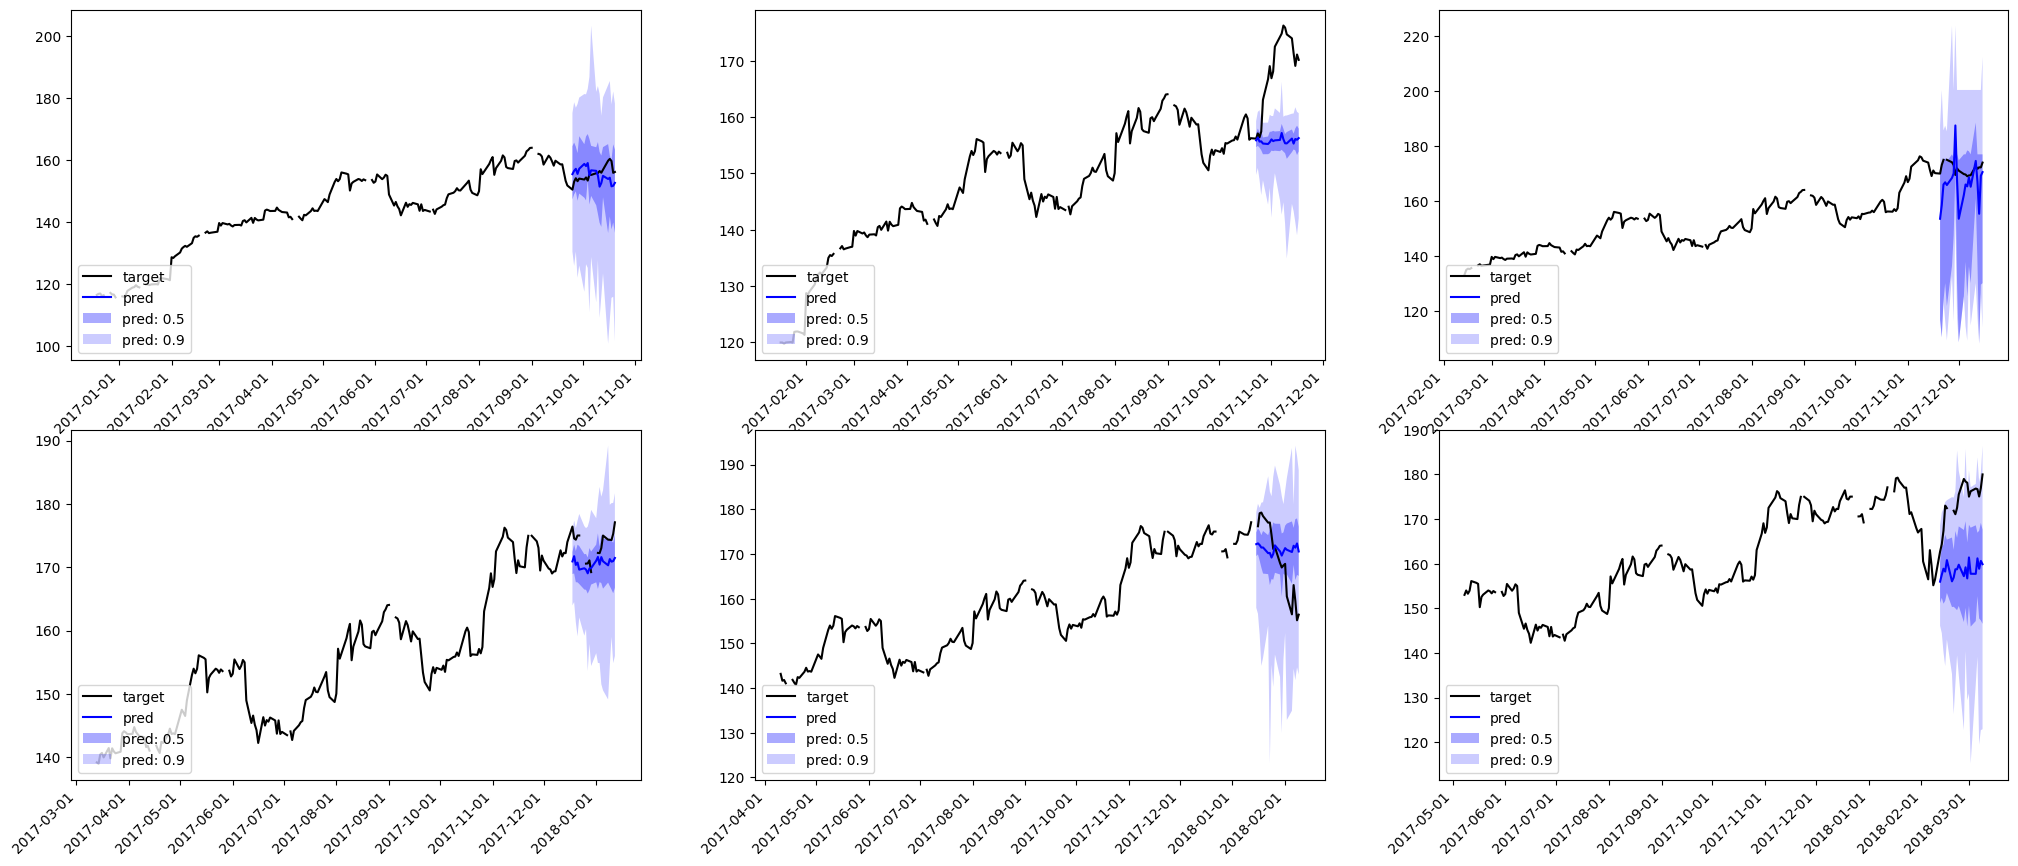

In [18]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)